In [108]:
#setup
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from IPython.display import display
from unidecode import unidecode
from gensim.corpora import Dictionary

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme()
plt.rcParams["figure.figsize"] = (10,8)
# pd.options.mode.chained_assignment = None #disable a specific warning

In [110]:
from main import nlp_pipeline_result

# data = nlp_pipeline_result(
#     parser_parameters={
#         "remove_hashtag_word": True,
#         "replace_politics": True,
#         "replace_parties": True,
#     },
#     nlp_parameters={
#         "disable_parser": True,
#         "disable_ner": True
#     }
# )
# data['n_lemmas'] = data['Lemmas'].str.split().str.len()
# 
# data.to_csv('data/data.csv', index = False)

In [111]:
data = pd.read_csv('data/data.csv')

train = data.sample(frac=0.8, random_state=420)
test = data.drop(train.index)
data = train

print(f"Len data: {len(data)}")
print(f"Len train: {len(train)}")
print(f"Len test: {len(test)}")

Len data: 11850
Len train: 11850
Len test: 2962


In [ ]:
def remove_accents(sentence):
    parsed_sentence = []
    for word in sentence.split(" "):
        if "ñ" in word:
            parsed_sentence.append(word)
        else:
            parsed_sentence.append(unidecode(word))
    return " ".join(parsed_sentence)

In [112]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_accents(str(x).lower()))

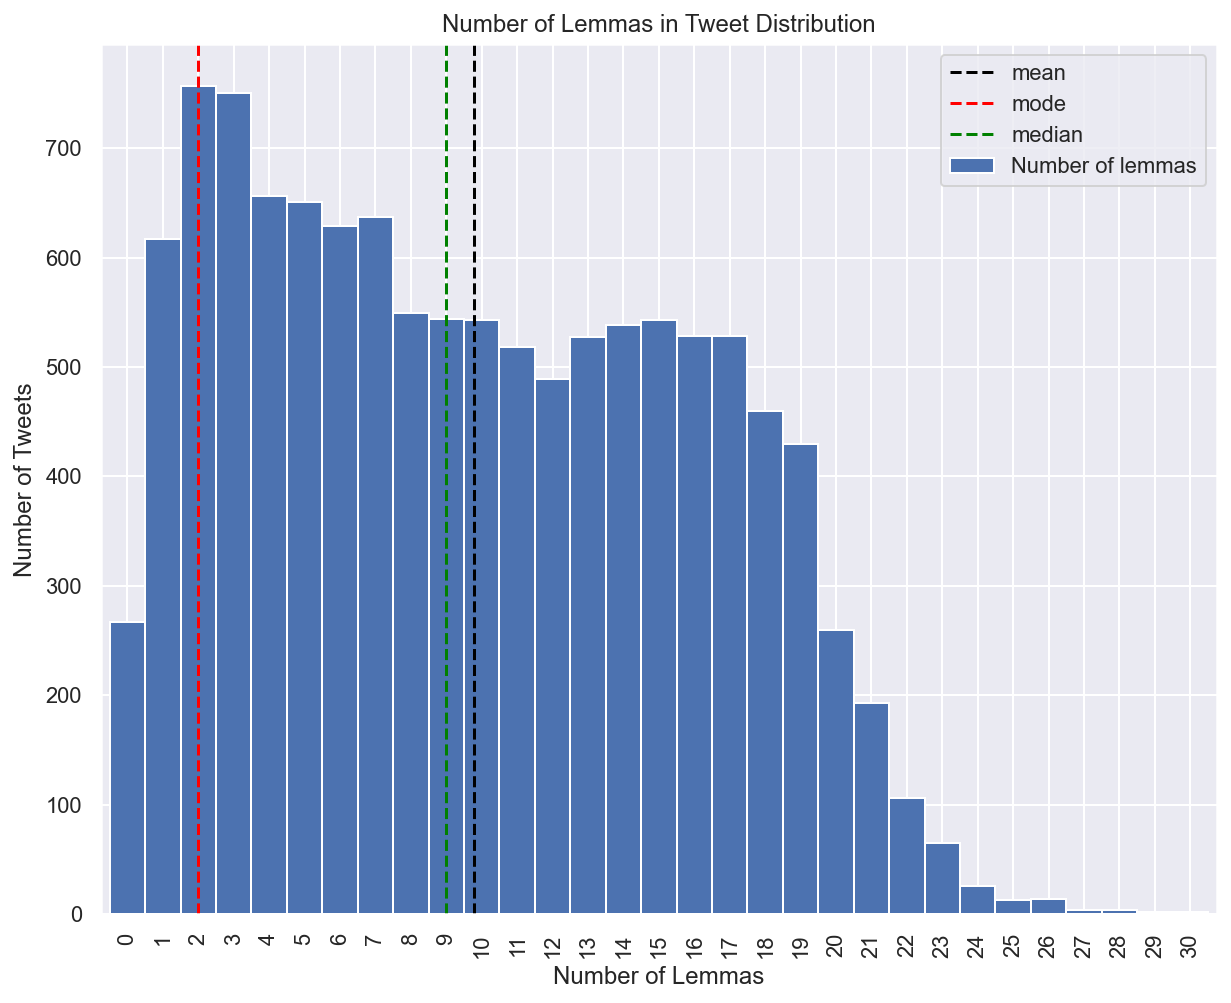

In [113]:
plt.figure()
data['n_lemmas'].value_counts().sort_index().plot(kind="bar", width=1, label='Number of lemmas')
plt.axvline(x=data['n_lemmas'].mean(),
            label='mean', color='black',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].mode()[0],
            label='mode', color='red',
            linestyle = '--')
plt.axvline(x=data['n_lemmas'].median(),
            label='median', color='green',
            linestyle = '--')
plt.legend()
plt.title('Number of Lemmas in Tweet Distribution')
plt.xlabel('Number of Lemmas')
plt.ylabel('Number of Tweets')
plt.show()

In [114]:
data = data[data['n_lemmas'] >= 3]
print(f'Number of Tweets in Dataframe after removing short tweets: {len(data)}')

Number of Tweets in Dataframe after removing short tweets: 10209


In [115]:
tweets_corpus = [el.split() for el in data["Lemmas"]]

In [116]:
token_dic = Dictionary(tweets_corpus)

In [117]:
word_freq = {}
for k, v in token_dic.items():
    word_freq[v] = token_dic.cfs[k]

sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
print(sorted_word_freq)

{'madrid': 937, 'gobierno': 922, 'el': 889, 'vox': 781, 'pp': 769, 'españa': 654, 'psoe': 559, 'gracias': 543, 'año': 523, 'libertad': 470, 'seguir': 463, 'ley': 434, 'español': 416, 'sanchez': 414, 'pais': 365, 'derecho': 361, 'persona': 349, 'violencia': 337, 'politica': 322, 'votar': 319, 'democracia': 318, 'ver': 295, 'defender': 294, 'publico': 288, 'dejar': 281, 'izquierda': 281, 'querer': 279, 'ayuso': 277, 'via': 267, 'decir': 263, 'congreso': 258, 'partido': 256, 'social': 256, 'mujer': 255, 'pasar': 255, 'apoyo': 253, 'iglesias': 253, 'frente': 246, 'millon': 246, 'odio': 239, 'politico': 235, 'cambio': 233, 'hablar': 232, 'pedir': 230, 'vida': 229, 'unidas': 227, 'familia': 225, 'yo': 220, 'presidente': 218, 'mayo': 216, 'campaña': 213, 'vacuna': 212, 'plan': 208, 'voto': 206, 'poner': 205, 'hacer': 202, 'madrileño': 198, 'futuro': 198, 'compañero': 195, 'amenaza': 194, 'derecha': 193, 'gente': 193, 'trabajador': 186, 'pablo': 183, 'impuesto': 180, 'quedar': 180, 'climatico'

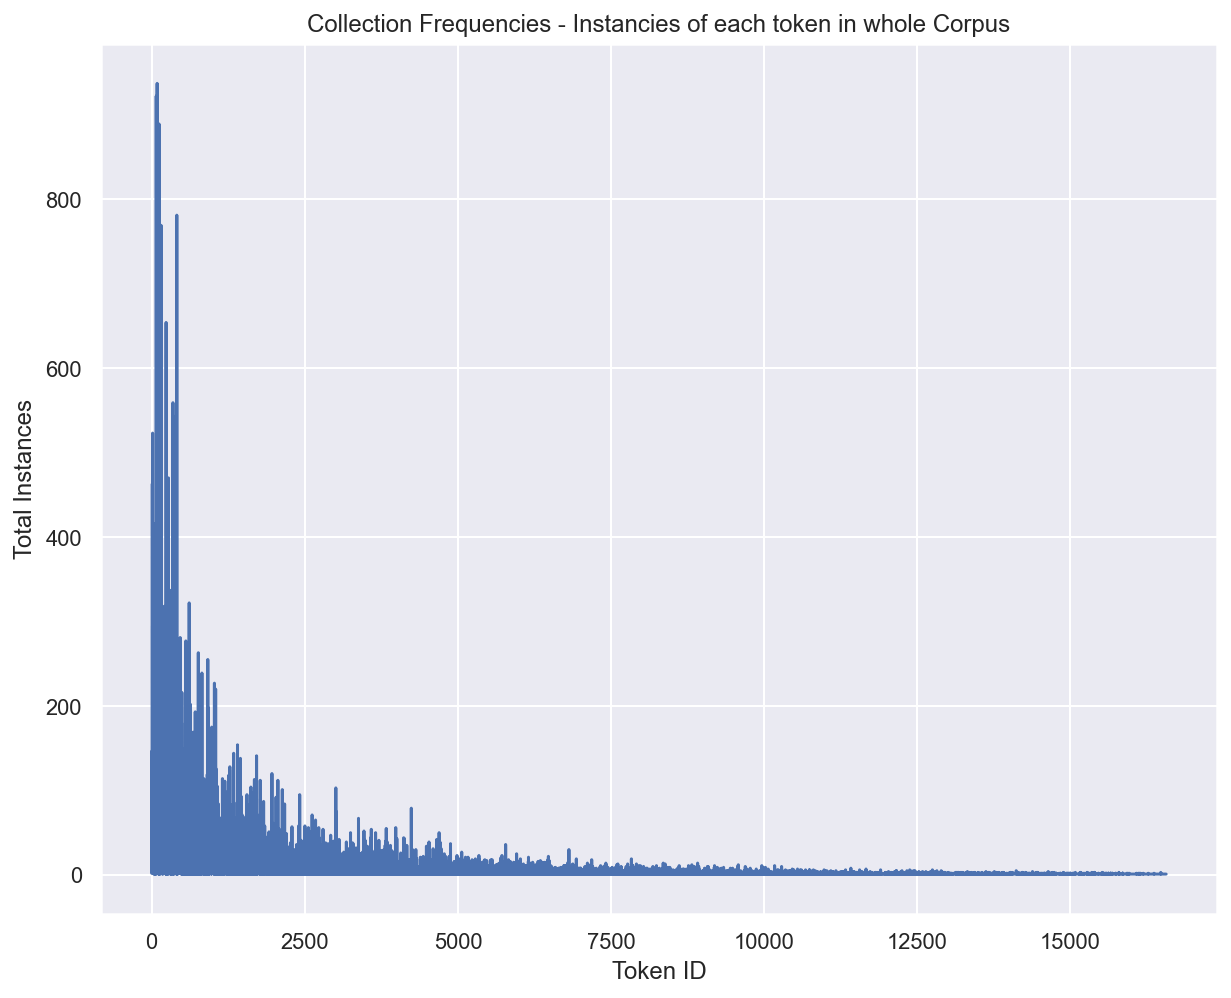

Max of occurances per topic: 937
Mean of occurances per topic: 6.8694680915293125


In [118]:
# Collection frequencies: token_id -> how many instances of this token are contained in the documents.
collfreq = sorted(token_dic.cfs.items()) 
x, y = zip(*collfreq) 
plt.plot(x, y)
plt.title('Collection Frequencies - Instancies of each token in whole Corpus')
plt.xlabel('Token ID')
plt.ylabel('Total Instances')
plt.show()

# MEAN
count = 0
_sum = 0
for key in token_dic.cfs:
    count += 1
    _sum += token_dic.cfs[key]

instances_mean = _sum/count

#MAX
instances_max = max(token_dic.cfs.values())

print(f"Max of occurances per topic: {instances_max}")
print(f"Mean of occurances per topic: {instances_mean}")

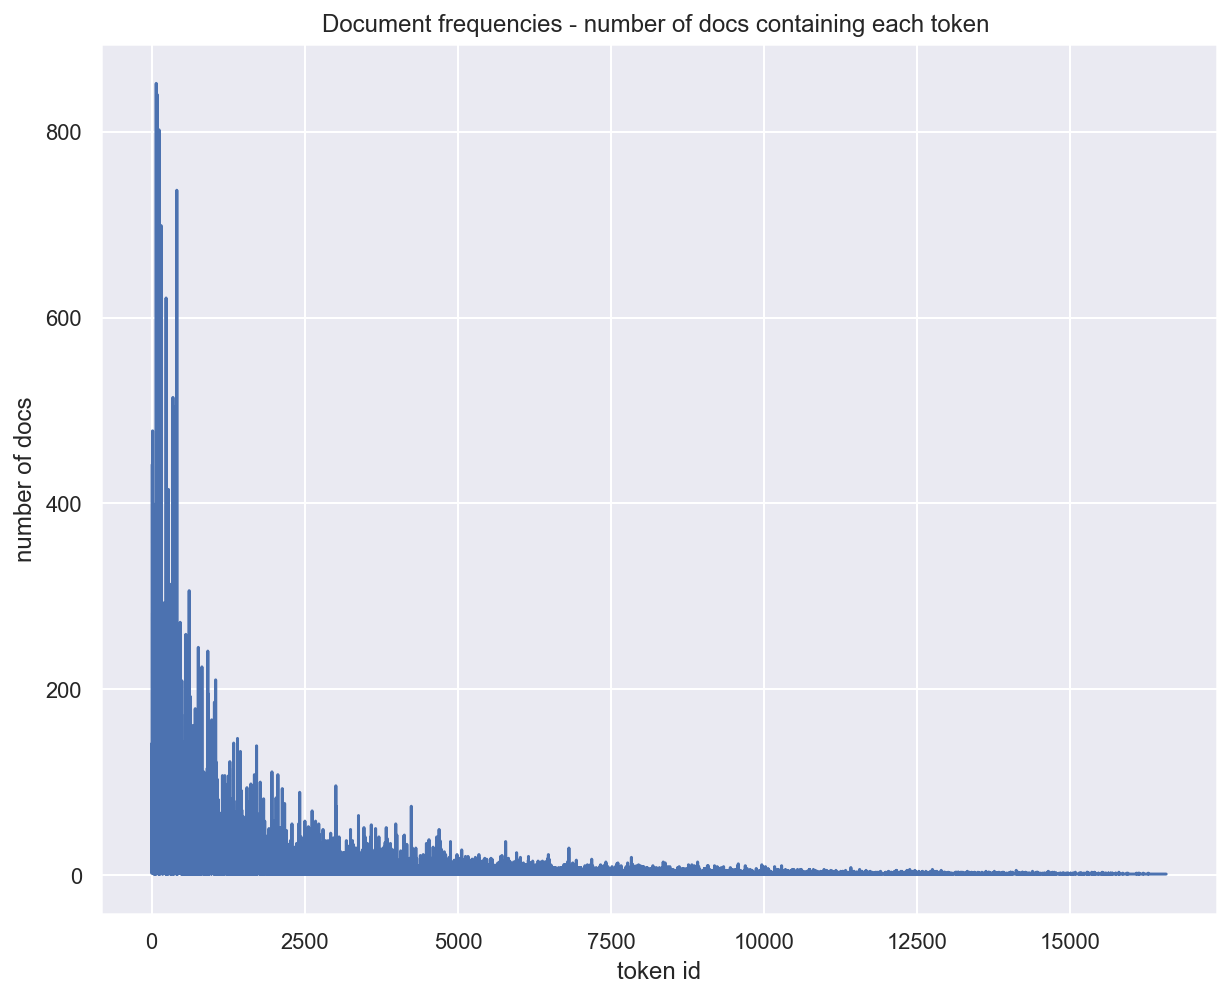

Max of docs in which a token appears: 852
Mean of docs in which token appears: 6.622532149972831


In [119]:
# Document frequencies: token_id -> how many documents contain this token
docfreq = sorted(token_dic.dfs.items()) 
j, k = zip(*docfreq) 
plt.plot(j, k)
plt.title('Document frequencies - number of docs containing each token ')
plt.xlabel('token id')
plt.ylabel('number of docs')
plt.show()

# MEAN
count = 0
_sum = 0
for key in token_dic.dfs:
    count += 1
    _sum += token_dic.dfs[key]

docs_mean = _sum/count

#MAX
docs_max = max(token_dic.dfs.values())

print(f"Max of docs in which a token appears: {docs_max}")
print(f"Mean of docs in which token appears: {docs_mean}")

In [120]:
#FILTER TOKEN DICTIONARY

no_below_list = [1,2,3,4,5,6,7,8,9,10] #Minimum number of documents to keep a term in the dictionary
no_above_list = [.5, .4, .3, .2, .05, .04, .03, .02, .005, .004, .003, .002, .0005, .0004, 0.0003, .0002] #Maximum proportion of documents in which a term can appear to be kept in the dictionary

prev_dic = copy.copy(token_dic)
prev_tokens = len(token_dic)


# print('The dictionary contained', prev_tokens, 'terms')

# for i in no_below_list:
    
#     for j in no_above_list:
        
#         token_dic = Dictionary(tweets_corpus)
        
#         token_dic.filter_extremes(no_below=i,no_above=j)
        
#         n_tokens = len(token_dic)
        
#         print(n_tokens, 'terms |no_below = ', i, "| no_above = ", j)



#print('First terms in the dictionary:')
#for n in range(500):
#    print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY

In [121]:
token_dic.filter_extremes(no_below=3,no_above=1)
# no filtramos con no_above porque los tweets son documentos con muy pocas palabras 

# for n in range(500):
#     print(str(n), ':', token_dic[n])#FILTER TOKEN DICTIONARY

print(f'The dictionary contains {len(token_dic)} terms')

The dictionary contains 5151 terms


In [122]:
# BOW: Transform list of tokens into list of tuples (token id, token # of occurrences)

tweets_corpus_bow = [token_dic.doc2bow(doc) for doc in tweets_corpus]
# tweets_corpus_bow

In [123]:
import os
from gensim.models.wrappers import LdaMallet

os.environ['MALLET_HOME'] = r'C:/mallet'
mallet_path = 'C:/mallet/bin/mallet'
# mallet_path = '/Users/bernardobouzas/Downloads/mallet-2.0.8/bin/mallet'

num_topics = 60

ldamallet = LdaMallet(
    mallet_path,
    corpus=tweets_corpus_bow,
    num_topics=num_topics,
    id2word=token_dic,
    alpha=5,
    iterations=100
)

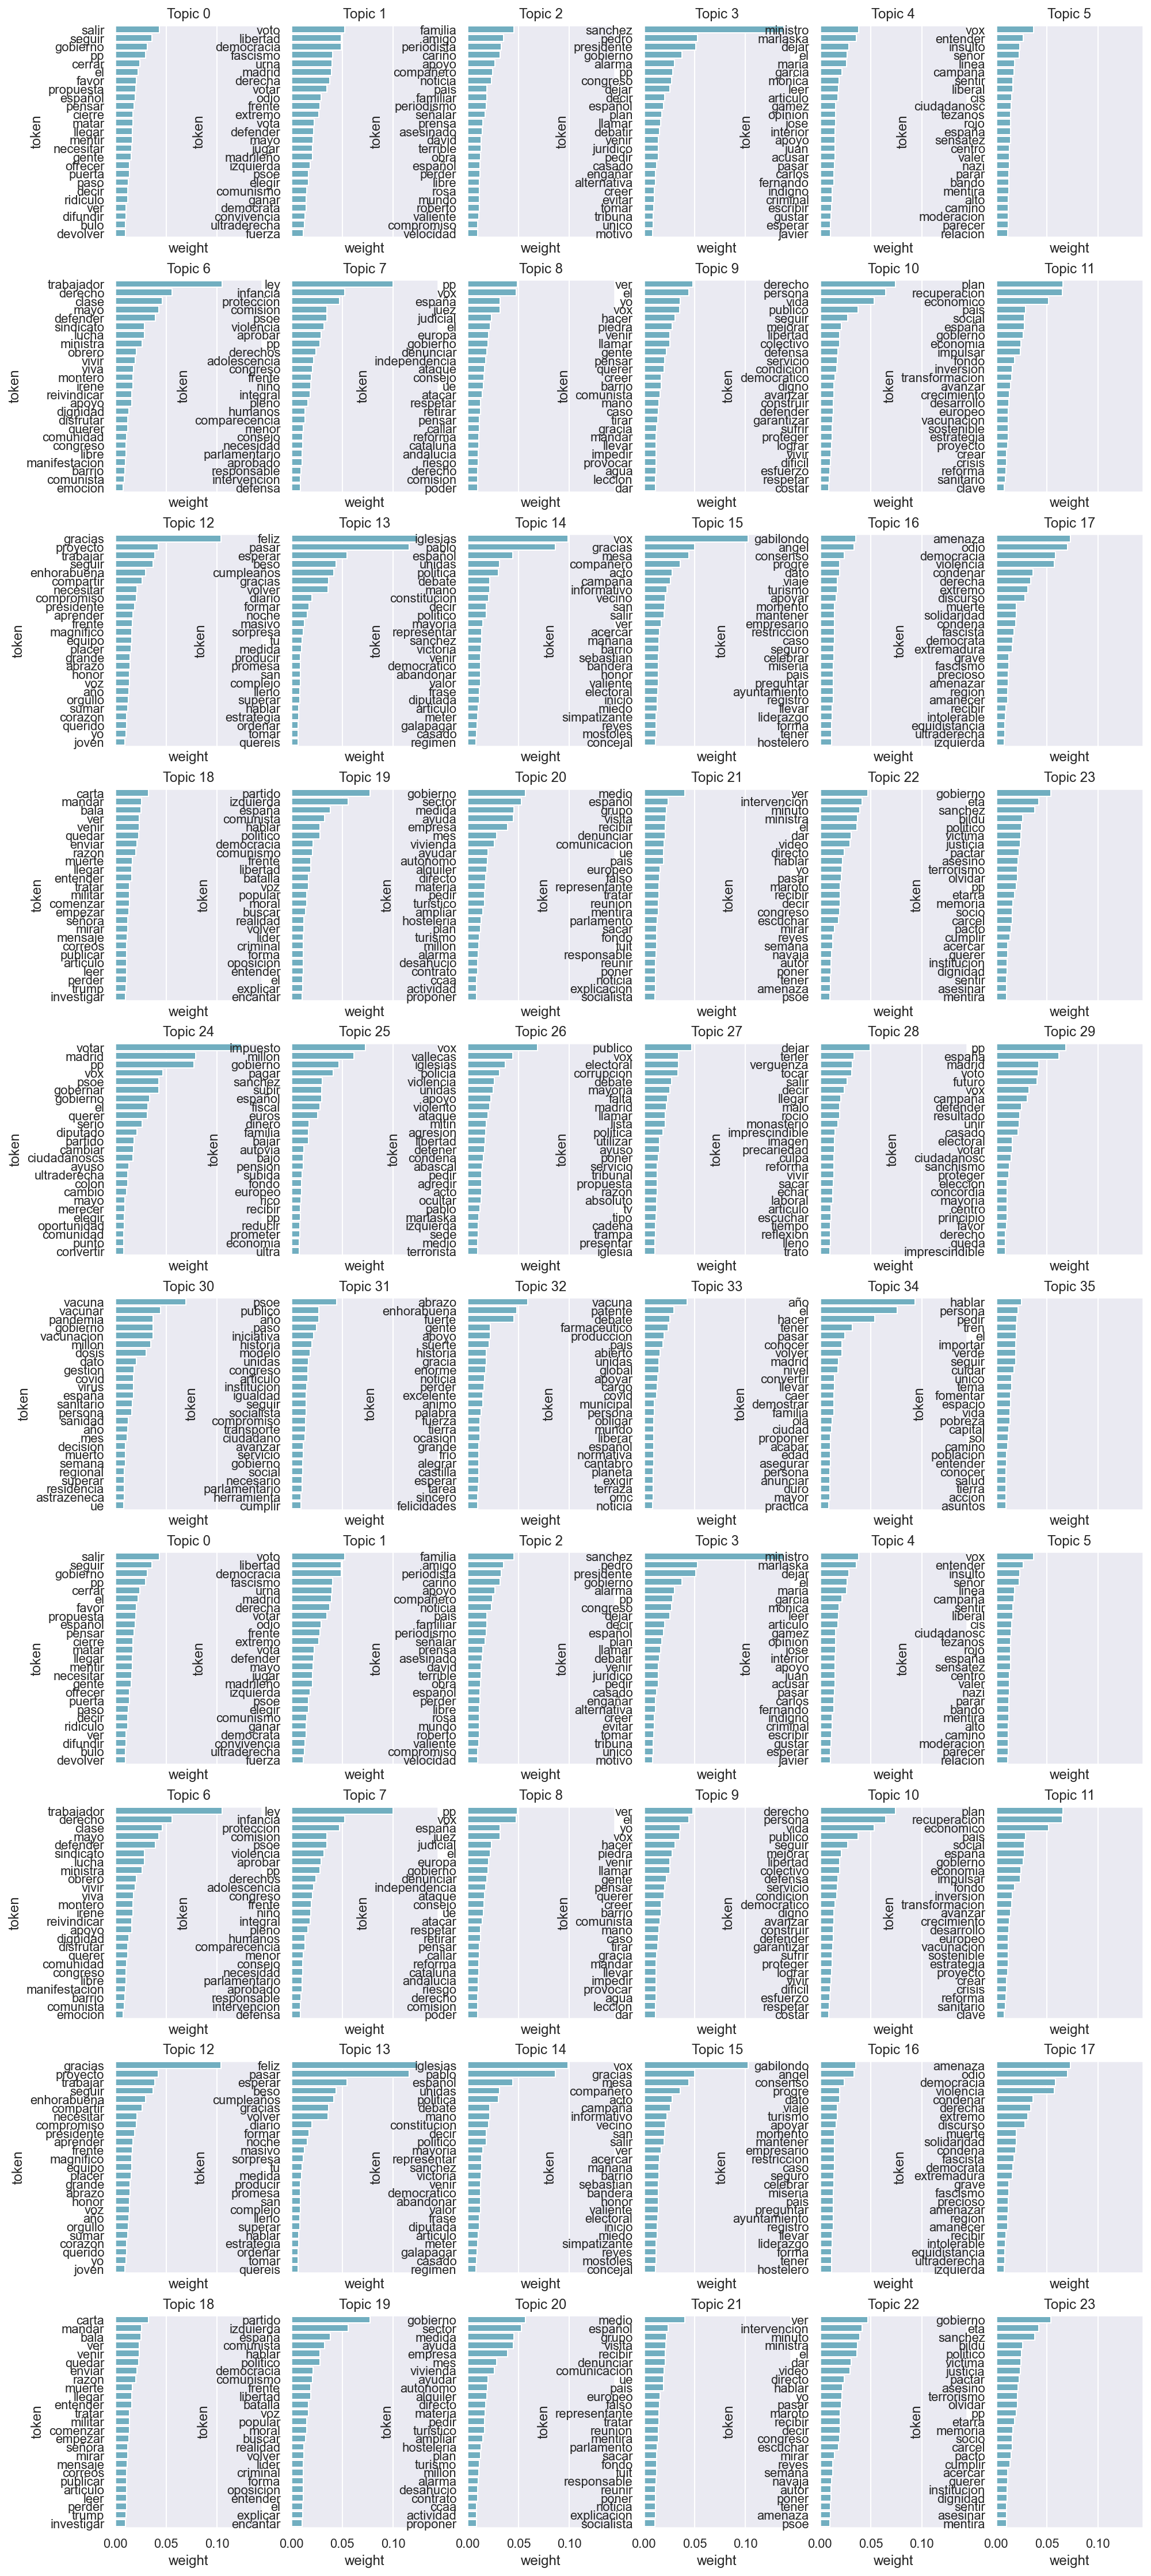

In [124]:
topn = 25
fig, axes = plt.subplots(10, 6, figsize=(16, 40), sharex=True)

for i in range(10):
    for j in range(6):
        df = pd.DataFrame(ldamallet.show_topic(j + 6*(i%6), topn=topn), columns=['token','weight'])
        sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=axes[i][j])
        axes[i][j].set_title(f'Topic {j + 6*(i%6)}')

plt.show()

In [125]:
specific_stw = [
    'el', 'año', 'vivir', 'hacer', 'plan',
    'sector', 'salir', 'gestion', 'resto',
    'ir', 'yo', 'ley', 'gobierno', 'serio',
    'nacional', 'acto', 'minuto', 'explicar',
    'estar', 'poner', 'discurso', 'pedir',
    'volver', 'alto', 'punto', 'pasar', 'pais',
    'dar', 'quedar', 'hablar', 'decir', 'dejar',
    'ver', 'paso', 'importante', 'aprobar', 'gente'
]

specific_stw = [
    'dato', 'llegar', 'politica', 'venir', 'leer',
    'seguir', 'entender', 'tener', 'llevar', 'convertir',
    'directo', 'partido', 'cara', 'caso', 'hilo', 'gracia',
    'favor', 'medio', 'forma', 'senor', 'empezar'
]

specific_stw = list(set([el.lower() for el in specific_stw]))

In [126]:
def remove_stpwrd(string, specific_stw_eliminate):
    splitted = string.split()
    resultwords  = [word for word in splitted if word.lower() not in specific_stw_eliminate]
    result = ' '.join(resultwords)
    return result

In [127]:
data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_stpwrd(str(x), specific_stw))

data['n_lemmas'] =  data['Lemmas'].str.split().str.len()
#print('Number of projects in DataFrame after applying specific stopwords and removing short texts:', len(NSF_df))

<ipython-input-127-d68b04cb4f4d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Lemmas'] = data['Lemmas'].apply(lambda x: remove_stpwrd(str(x), specific_stw))
<ipython-input-127-d68b04cb4f4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['n_lemmas'] =  data['Lemmas'].str.split().str.len()


In [128]:
tweets_corpus = [el.split() for el in data["Lemmas"]]
token_dic = Dictionary(tweets_corpus)
token_dic.filter_extremes(no_below=3, no_above=1)
tweets_corpus_bow = [token_dic.doc2bow(doc) for doc in tweets_corpus]

In [129]:
from gensim.models.wrappers import LdaMallet
import os
from gensim.models import LdaModel
#from gensim.models import CoherenceModel
from gensim.models.coherencemodel import CoherenceModel


In [130]:
list(range(60,3,-10))

[60, 50, 40, 30, 20, 10]

In [ ]:
tc = []
n_topics = range(150,3,-15)

for i, ntpc in enumerate(n_topics):
      lda_ntcp = LdaModel(corpus = tweets_corpus_bow, 
                          id2word = token_dic, 
                          num_topics = ntpc)
      
      tc.append(CoherenceModel(lda_ntcp,
                               texts = tweets_corpus,
                               dictionary = token_dic,
                               coherence = 'c_v').get_coherence())
      print(f'Tested {i+1} models out of {len(n_topics)}')

Tested 1 models out of 10
Tested 2 models out of 10
Tested 3 models out of 10
Tested 4 models out of 10


In [ ]:
plt.figure()
plt.plot(n_topics, tc)
plt.xticks(n_topics,n_topics)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

In [ ]:
#fine tune
n_topics = range(3,20,4)
tc = []

for ntpc in n_topics:
      lda_ntcp = LdaModel(corpus = tweets_corpus_bow, 
                          id2word = token_dic, 
                          num_topics = ntpc)
      
      tc.append(CoherenceModel(lda_ntcp,
                               texts = tweets_corpus,
                               dictionary = token_dic,
                               coherence = 'c_v').get_coherence())

plt.figure()
plt.plot(n_topics, tc)
plt.xlabel('Number of topics')
plt.ylabel('Average coherence')
plt.show()

In [ ]:
# print(list(ldamallet.load_document_topics()))
# print(len(list(ldamallet.load_document_topics())))

"""
rec = []
for topic in ldamallet.load_document_topics():
    rec.append([value[1] for value in topic])
       
df = pd.DataFrame(rec)

print(len(df), len(data))


df['Likes'] = data.sort_index()["Likes"].to_list()
df['Retweets'] = data.sort_index()["Retweets"].to_list()
df["Party"] = data.sort_index()["Party"].to_list()
df
"""